## 1: Machine Learning Methods


#### How can we use data analytics to predict energy usage for this house?


### 1. Read the dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df=pd.read_csv('energydata_complete-1 (1).csv')
df

### 2. Analyse and visualise the data

In [3]:
df = df[df['Appliances'].between(df['Appliances'].quantile(.0), df['Appliances'].quantile(.99))]
df['Date'] = pd.to_datetime(df['date']).dt.date
df['Time'] = pd.to_datetime(df['date']).dt.time
df['hour'] = pd.to_datetime(df['date']).dt.hour
df['month'] = pd.to_datetime(df['date']).dt.month
df['day']=pd.to_datetime(df['date']).dt.day
df['week']=pd.to_datetime(df['date']).dt.weekday
df['hour*lights'] = df.hour * df.lights
df['hour_avg'] = list(map(dict(df.groupby('hour')["Appliances"].mean()).get, df.hour))
df['day_avg'] = list(map(dict(df.groupby('day')["Appliances"].mean()).get, df.day))
df['month_avg'] = list(map(dict(df.groupby('month')["Appliances"].mean()).get, df.month))

C:\Users\tang xiaoqing\AppData\Local\Temp\ipykernel_47728\1321925088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['date']).dt.date
C:\Users\tang xiaoqing\AppData\Local\Temp\ipykernel_47728\1321925088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = pd.to_datetime(df['date']).dt.time
C:\Users\tang xiaoqing\AppData\Local\Temp\ipykernel_47728\1321925088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Text(0, 0.5, 'appliances')

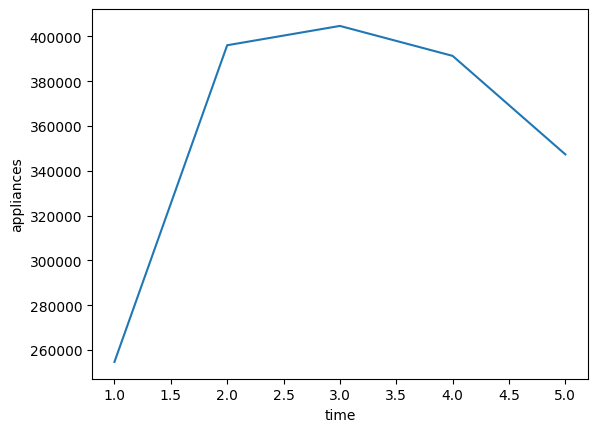

In [4]:
p=df.groupby('month')['Appliances'].sum()
plt.plot(p.index,p)
plt.xlabel('time')
plt.ylabel('appliances')

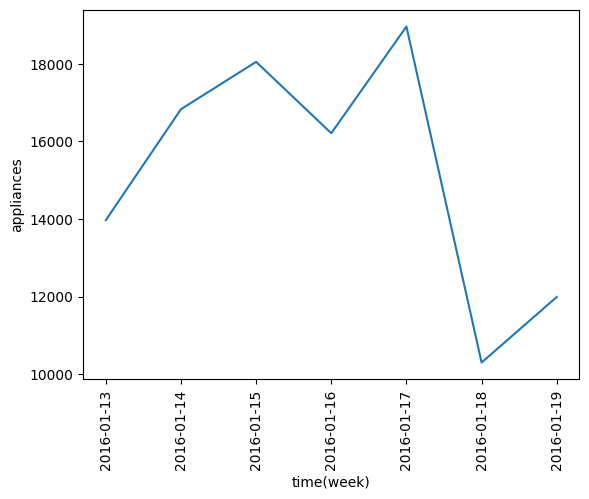

In [32]:
p=df.groupby('Date')['Appliances'].sum()
plt.plot(p.index[2:9],p[2:9])
plt.xlabel('time(week)')
plt.ylabel('appliances')
plt.xticks(rotation=90)
plt.show()

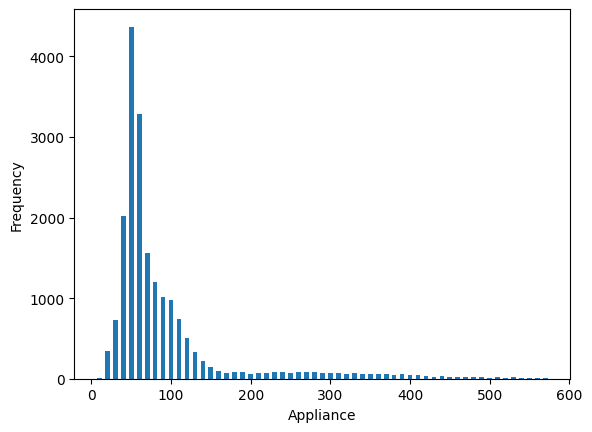

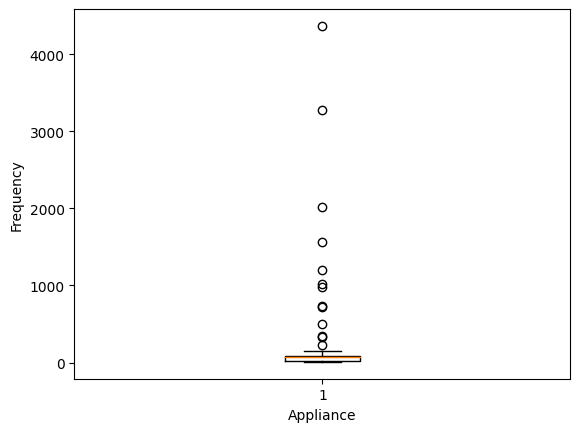

In [34]:
h=df.groupby('Appliances')['date'].count()
plt.bar(h.index,h,width=6)
plt.xlabel('Appliance')
plt.ylabel('Frequency')
plt.show()
plt.boxplot(h)
plt.xlabel('Appliance')
plt.ylabel('Frequency')
plt.show()

C:\Users\tang xiaoqing\AppData\Local\Temp\ipykernel_47728\1287621975.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr=df.corr()


<AxesSubplot: >

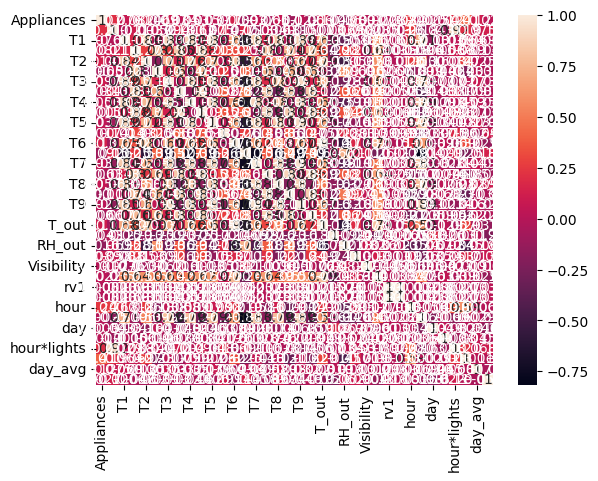

In [40]:
df_corr=df.corr()
d=df_corr['Appliances'].sort_values(ascending=False)
sns.heatmap(df_corr,annot=True)



Text(50.722222222222214, 0.5, 'hour of day')

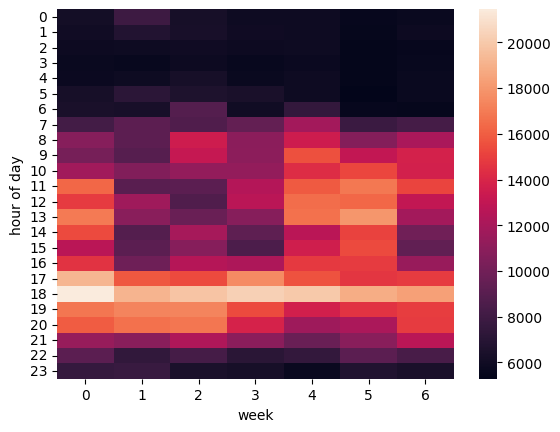

In [64]:
u=df.groupby(['hour','week'])['Appliances'].sum()
sns.heatmap(np.array(u).reshape(24,7))
plt.xlabel("week")
plt.ylabel("hour of day")

In [39]:
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
df1=df.drop(columns=['date','Date','Time'])
rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
boruta_model = BorutaPy(
        estimator=rf,
        n_estimators='auto',
        max_iter=100  
    )
boruta_model.fit(np.array(df1.iloc[:,1:]), np.array(df1.iloc[:,0]))

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=144,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x1AA35ABF440),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1AA35ABF440)

In [50]:
index=np.squeeze(np.argwhere(boruta_model.ranking_==1))
d=[]
for i in range(1,100):
    rf1= RandomForestRegressor(n_estimators=i,n_jobs=-1, max_depth=5)
    rf1.fit(df1.iloc[:,index[1:]],df1.iloc[:,0])
    d.append(rf1.feature_importances_)
    

<AxesSubplot: >

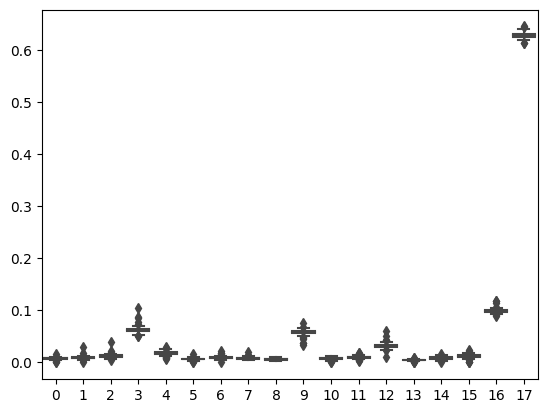

In [56]:

sns.boxplot(pd.DataFrame(pd.DataFrame(np.array(d))))

In [10]:
df_index=d[d>=0.2].index
df_index

Index(['Appliances', 'hour_avg', 'hour', 'lights'], dtype='object')

In [11]:
df=df[df_index]
df

,Appliances,hour_avg,hour,lights
0,60,141.919699,17,30
1,60,141.919699,17,30
2,50,141.919699,17,30
3,50,141.919699,17,40
4,60,141.919699,17,40
...,...,...,...,...
19730,100,141.919699,17,0
19731,90,141.919699,17,0
19732,270,141.919699,17,10
19733,420,141.919699,17,10


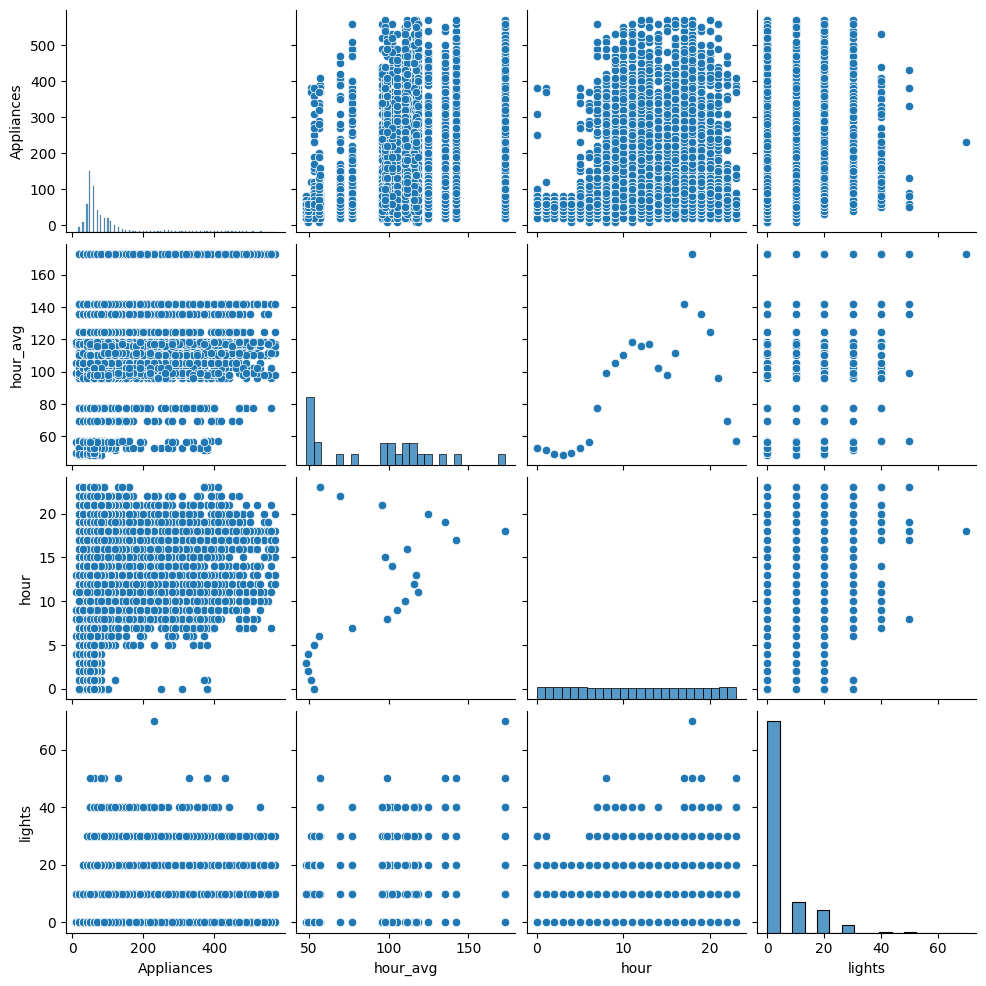

In [12]:
sns.pairplot(df)

### 3. Implement prediction models

In [13]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df.iloc[:,1:],df.iloc[:,0])
model1=linear_model.LinearRegression()
model2=RandomForestRegressor()



### 4. Train prediction models

In [14]:
model1.fit(x_train,y_train)
model2.fit(x_train,y_train)


RandomForestRegressor()

### 5. Test predictin models and show results

In [15]:
import matplotlib.pyplot as plt
pred1=model1.predict(x_test)
pred2=model2.predict(x_test)
print(model1.feature_names_in_,model1.coef_,pred1)
print(model2.feature_names_in_,model2.feature_importances_,pred2)



['hour_avg' 'hour' 'lights'] [ 0.9794982  -0.33650782  1.52655435] [ 47.55173979  91.39133397 110.64808055 ...  47.55173979 104.35410385
 110.64808055]
['hour_avg' 'hour' 'lights'] [0.80990933 0.02883718 0.1612535 ] [ 48.86515726  93.43860945 109.11040567 ...  48.86515726 107.2205865
 109.11040567]


<BarContainer object of 3 artists>

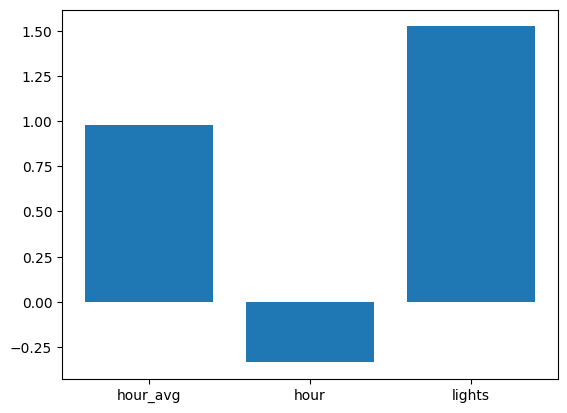

In [16]:
plt.bar(model1.feature_names_in_,model1.coef_)


<BarContainer object of 3 artists>

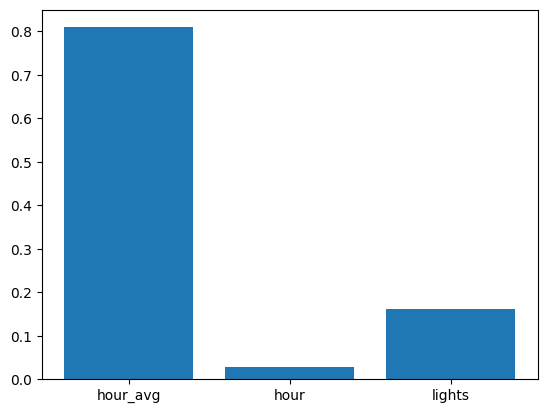

In [17]:
plt.bar(model2.feature_names_in_,model2.feature_importances_)


In [18]:
model2.feature_importances_

array([0.80990933, 0.02883718, 0.1612535 ])

### 6. Compare the results from all candidate models, choose the best model, justify your choice and discuss the results

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
loss1=model1.score(x_test,y_test)
loss2=model2.score(x_test,y_test)
print(np.sqrt(mean_squared_error(y_test,pred1)),np.sqrt(mean_squared_error(y_test,pred2)))
print(loss1,loss2)#选择线性回归模型

74.1873153526552 73.93291208105207
0.17930527361110093 0.18492427829650349


In [104]:
df2=df1.iloc[:,index]
x_train1,x_test1,y_train1,y_test1=train_test_split(df2.iloc[:,1:],df2.iloc[:,0])

In [130]:
loss=[]
for i in range(len(rf1.feature_names_in_)):
    lr2=RandomForestRegressor()
    lr2.fit(x_train1.iloc[:,:i+1],y_train1)
    pred=lr2.predict(x_test1.iloc[:,:i+1])
    loss.append(np.sqrt(mean_squared_error(y_test1,pred)))

Text(0, 0.5, 'RMSE')

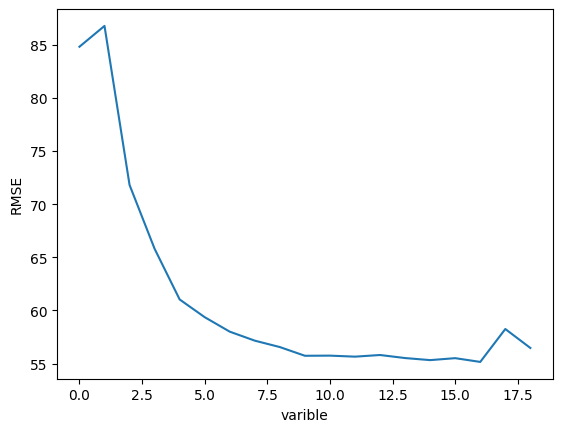

In [131]:
plt.plot(np.arange(len(loss)),loss)
plt.xlabel('varible')
plt.ylabel('RMSE')

In [132]:
loss1=[]
for i in range(len(rf1.feature_names_in_)):
    lr2=linear_model.LinearRegression()
    lr2.fit(x_train1.iloc[:,:i+1],y_train1)
    pred=lr2.predict(x_test1.iloc[:,:i+1])
    
    loss1.append(np.sqrt(mean_squared_error(y_test1,pred)))

Text(0, 0.5, 'RMSE')

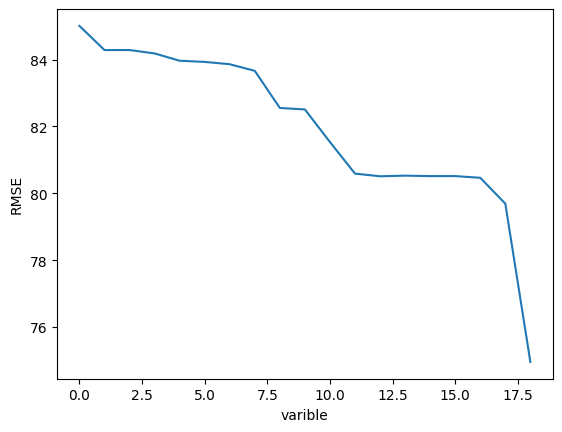

In [133]:
plt.plot(np.arange(len(loss1)),loss1)
plt.xlabel('varible')
plt.ylabel('RMSE')

<AxesSubplot: >

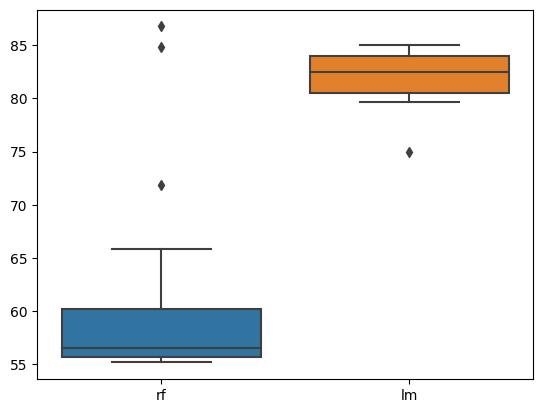

In [136]:
a=pd.DataFrame([loss,loss1]).T
a.columns=['rf','lm']
sns.boxplot(a)


### 7. Reflect on what you have learned by completing this assignment

Learned how to build regression models through sklearn database, such as linear regression, random forest regression, etc., and learned to sort out the characteristics of time series, such as day_ Avg, etc., know how to evaluate regression models, such as mae, mse, rmse, etc

### 8. References

## 2: Time Series Forecasting


#### Follow detail instructions in the assignment specification and use these heading for implementation and discussion

### 1. Read the dataset

In [20]:
df=pd.read_csv('energydata_complete-1 (1).csv')
df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


### 2. Analyse and visualise the data

In [21]:

df=df.set_index('date')


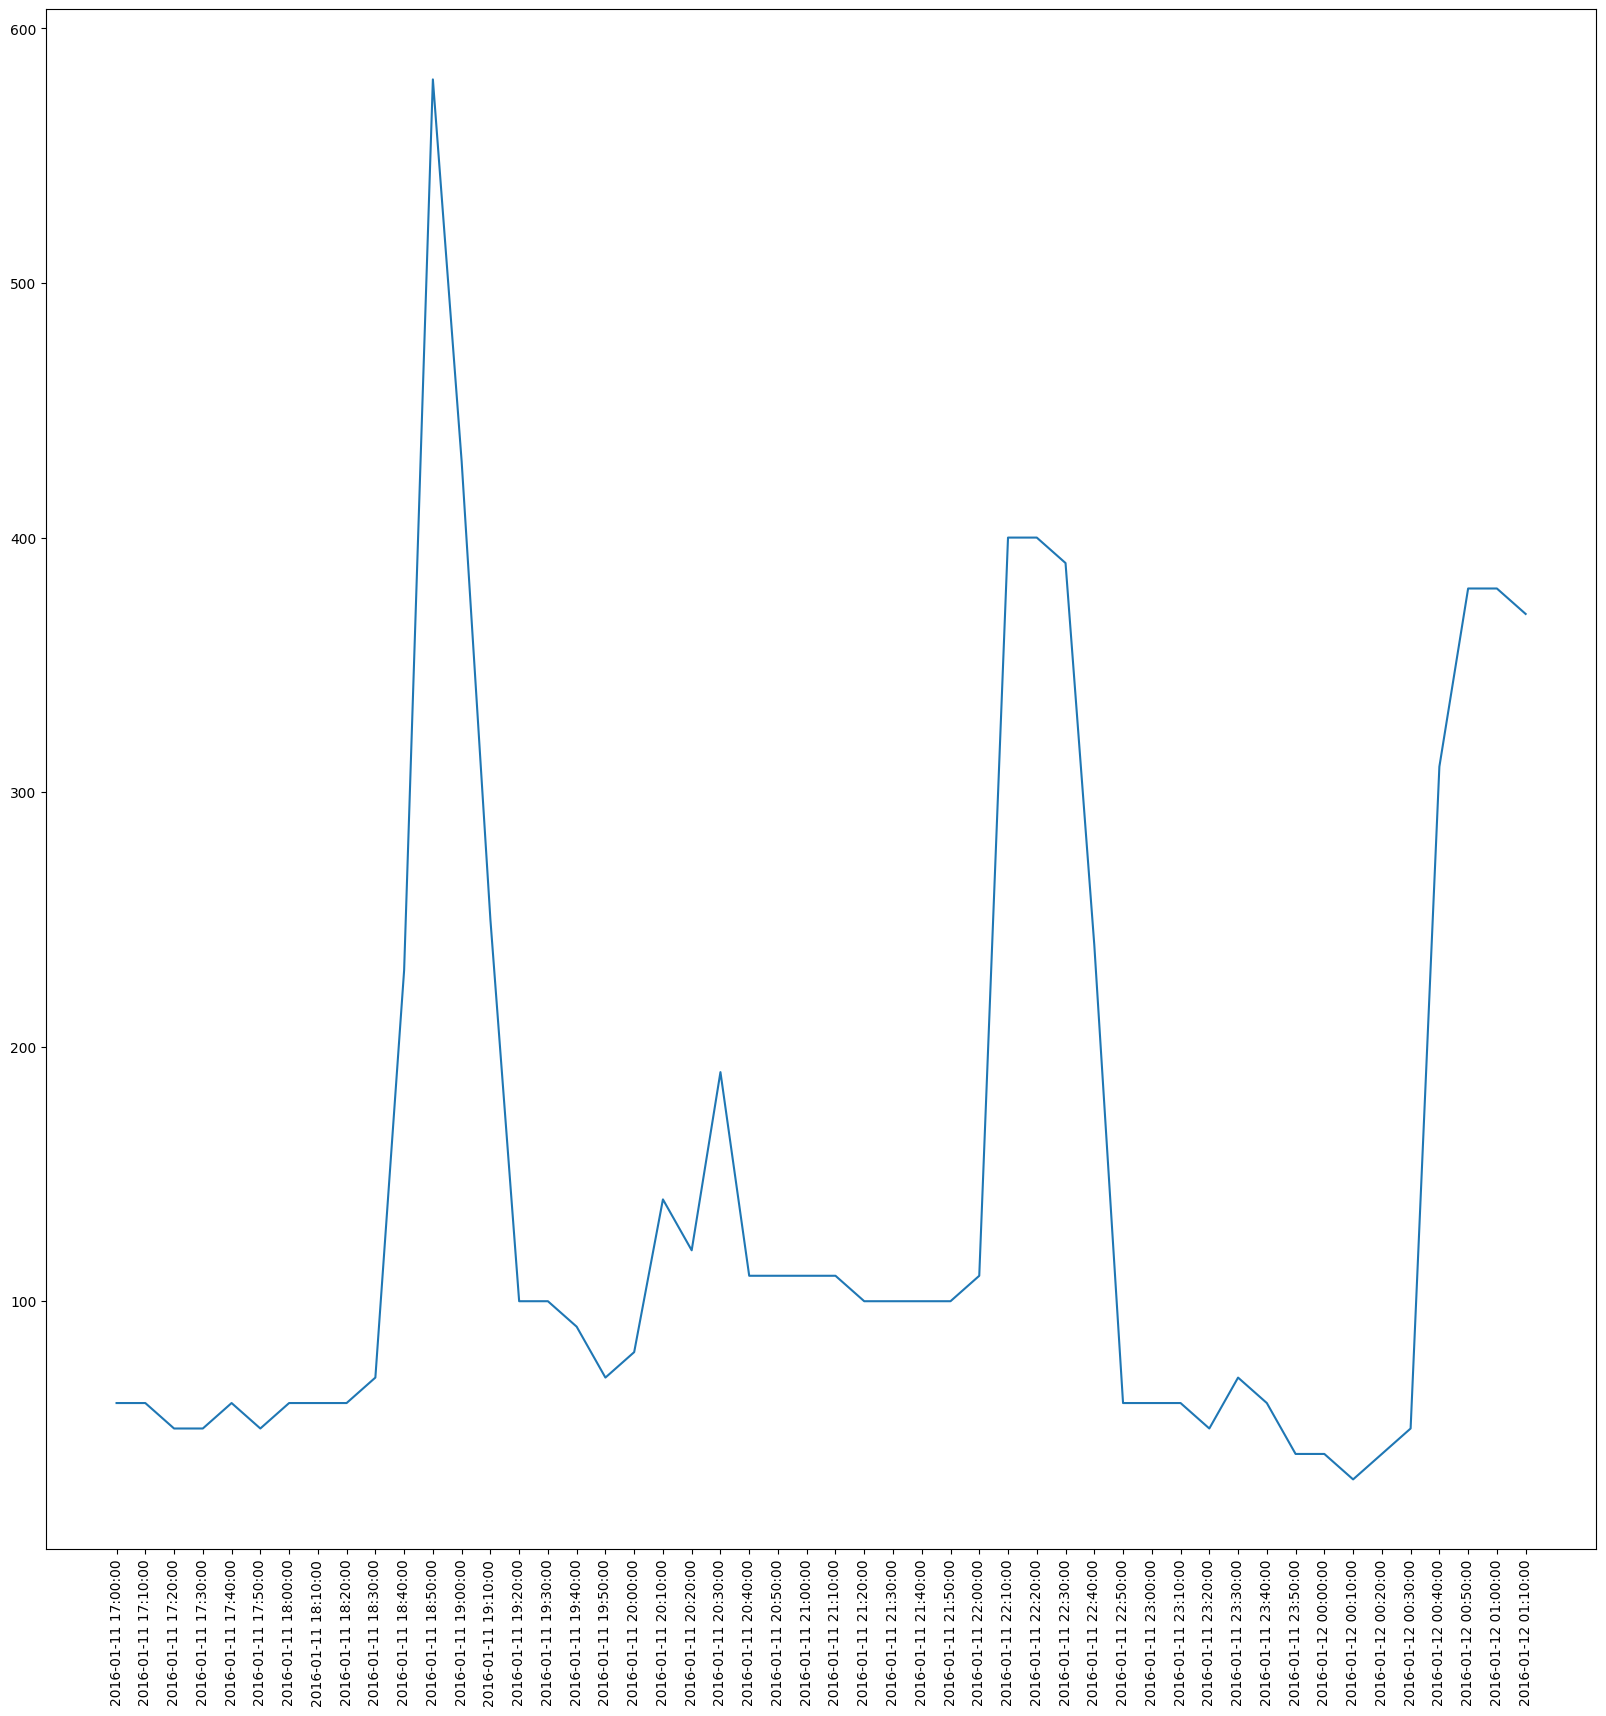

In [22]:
plt.figure(figsize=(20,20))
plt.plot(df.index[:50],df['Appliances'][:50])
plt.xticks(rotation=90)
plt.show()


In [23]:
train=df.loc[:'2016-05-27 00:00:00',:]
test=df.loc['2016-05-27 00:00:00':,:]


In [24]:
import statsmodels.api as sm
sm.tsa.stattools.adfuller(train['Appliances'])

(-21.60529384578903,
 0.0,
 11,
 19615,
 {'1%': -3.4306834262544017,
  '5%': -2.8616873625266015,
  '10%': -2.566848437074011},
 219287.2793560049)

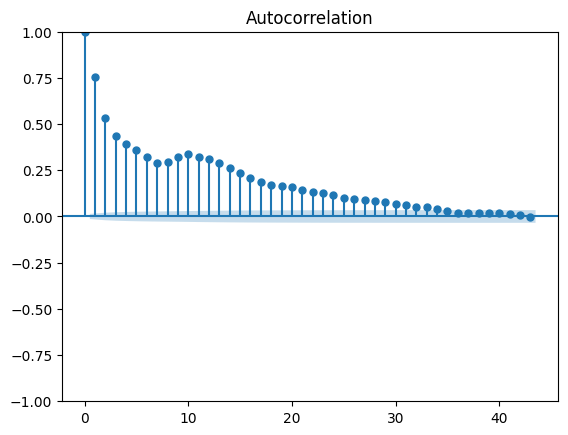

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
acf=plot_acf(train['Appliances'])#展示
plt.show()

d:\anaconda\envs\tf_gpu\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


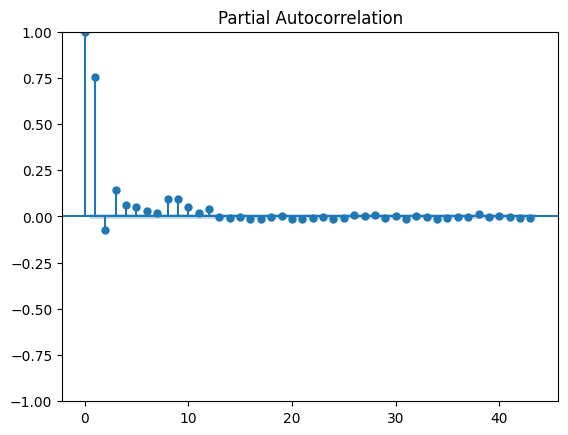

In [26]:
pacf=plot_pacf(train['Appliances'])
plt.show()

In [27]:
df=pd.read_csv('energydata_complete-1 (1).csv')
values=df.values
values[:,0] = pd.to_numeric(pd.to_datetime(values[:,0]))
values

array([[1452531600000000000, 60, 30, ..., 5.3, 13.275433157104999,
        13.275433157104999],
       [1452532200000000000, 60, 30, ..., 5.2, 18.606194981839508,
        18.606194981839508],
       [1452532800000000000, 50, 30, ..., 5.1, 28.64266816759482,
        28.64266816759482],
       ...,
       [1464370800000000000, 270, 10, ..., 13.2666666666667,
        29.19911708449945, 29.19911708449945],
       [1464371400000000000, 420, 10, ..., 13.2333333333333,
        6.322783650830388, 6.322783650830388],
       [1464372000000000000, 430, 10, ..., 13.2, 34.11885058740154,
        34.11885058740154]], dtype=object)

In [28]:
def series_to_supevised(dataset, n_in=1, n_out=1, dropnan=True):
    num_vars = 1 if type(dataset) is list else dataset.shape[1]
    dataframe = pd.DataFrame(dataset)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(dataframe.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_vars)]
    for i in range(0, n_out):
        cols.append(dataframe.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supevised(scaled, 1, 1)
reframed.drop(reframed.columns[[29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57]], axis=1, inplace=True)
print("reframed: ", reframed.shape, "reframed head: ", reframed.head())
values = reframed.values
X = values[:,:29]
Y = values[:,29]
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.3)
X_Train = X_Train.reshape((X_Train.shape[0], 1, X_Train.shape[1]))
X_Test = X_Test.reshape((X_Test.shape[0], 1, X_Test.shape[1]))
print(X_Train.shape[1])
print(X_Train.shape[2])

reframed:  (19734, 30) reframed head:     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.046729   0.428571    0.32735   0.566187   0.225345   
2   0.000051   0.046729   0.428571    0.32735   0.541326   0.225345   
3   0.000101   0.037383   0.428571    0.32735   0.530502   0.225345   
4   0.000152   0.037383   0.571429    0.32735   0.524080   0.225345   
5   0.000203   0.046729   0.571429    0.32735   0.531419   0.225345   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var21(t-1)  var22(t-1)  \
1   0.684038   0.215188   0.746066    0.351351  ...    0.677290    0.372990   
2   0.682140   0.215188   0.748871    0.351351  ...    0.678532    0.369239   
3   0.679445   0.215188   0.755569    0.344745  ...    0.676049    0.365488   
4   0.678414   0.215188   0.758685    0.341441  ...    0.671909    0.361736   
5   0.676727   0.215188   0.758685    0.341441  ...    0.671909    0.357985   

   var23(t-1)  var24(t-1)  var25(t-1)  var26(t-1)  var27(t-

### 3. Implement prediction models

In [30]:
import statsmodels.api as sm
import tensorflow as tf 
from keras.layers import LSTM, GRU, Bidirectional, Dropout, Concatenate, CuDNNLSTM, CuDNNGRU, SimpleRNN, Conv1D,GlobalMaxPooling1D,TimeDistributed, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add((LSTM(40,return_sequences=True, input_shape=(X_Train.shape[1], X_Train.shape[2]))))
model.add(Dropout(0.2))
model.add((LSTM(20,return_sequences=True)))
model.add(Dropout(0.3))
model.add((LSTM(20,return_sequences=False)))
model.add(Dropout(0.2))

model.add(Dense(1,activation='ReLU'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy', 'mse','mae','mape','msle'])



callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

model1 = sm.tsa.arima.ARIMA(pd.DataFrame(train['Appliances']),order=(2,0,10))


d:\anaconda\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
d:\anaconda\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
d:\anaconda\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


### 4. Train prediction models

In [31]:
arima_res=model1.fit()
arima_res.summary()
history = model.fit(X_Train, Y_Train, epochs=70, batch_size=128,callbacks=[callback], validation_data=(X_Test, Y_Test), verbose=2, shuffle=True)

Epoch 1/70
108/108 - 7s - loss: 0.0129 - accuracy: 0.7718 - mse: 0.0129 - mae: 0.0808 - mape: 38674680.0000 - msle: 0.0095 - val_loss: 0.0099 - val_accuracy: 0.7754 - val_mse: 0.0099 - val_mae: 0.0702 - val_mape: 35467048.0000 - val_msle: 0.0073
Epoch 2/70
108/108 - 1s - loss: 0.0075 - accuracy: 0.7718 - mse: 0.0075 - mae: 0.0527 - mape: 22673494.0000 - msle: 0.0055 - val_loss: 0.0046 - val_accuracy: 0.7754 - val_mse: 0.0046 - val_mae: 0.0397 - val_mape: 16835218.0000 - val_msle: 0.0035
Epoch 3/70
108/108 - 1s - loss: 0.0060 - accuracy: 0.7717 - mse: 0.0060 - mae: 0.0416 - mape: 14853569.0000 - msle: 0.0043 - val_loss: 0.0046 - val_accuracy: 0.7754 - val_mse: 0.0046 - val_mae: 0.0330 - val_mape: 8481047.0000 - val_msle: 0.0034
Epoch 4/70
108/108 - 1s - loss: 0.0056 - accuracy: 0.7719 - mse: 0.0056 - mae: 0.0393 - mape: 13359108.0000 - msle: 0.0041 - val_loss: 0.0045 - val_accuracy: 0.7754 - val_mse: 0.0045 - val_mae: 0.0342 - val_mape: 11074270.0000 - val_msle: 0.0033
Epoch 5/70
108/10

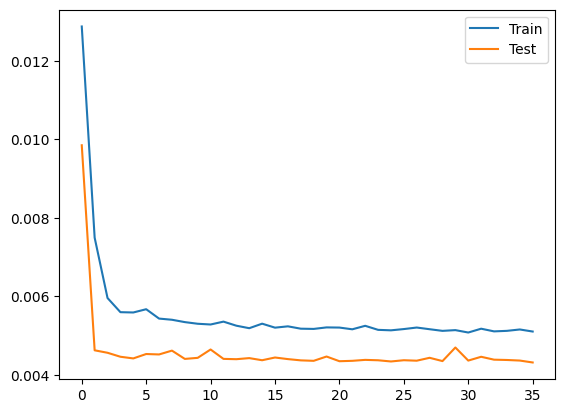

In [32]:
# plot history
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.show()

### 5. Test predictin models and show results

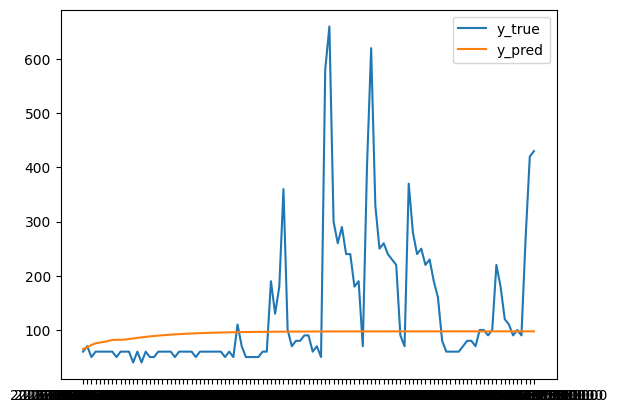

In [33]:
predict=arima_res.predict('2016-05-27 00:00:00','2016-05-27 18:00:00')
plt.plot(test.index,test['Appliances'])
plt.plot(test.index,predict)
plt.legend(['y_true','y_pred'])
plt.show()


In [34]:
pred1=model.predict(X_Test)
pred1

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

### 6. Compare the results from all candidate models, choose the best model, justify your choice and discuss the results

Compare the results from all candidate models, choose the best model, justify your choice and discuss the results.

Compare with the results you have obtained in Assignment 1.

In [35]:
from sklearn.metrics import r2_score,mean_absolute_error
print(mean_absolute_error(test['Appliances'],predict))
print(model.metrics_names)
model.evaluate(X_Test,Y_Test)#比较得出lstm 模型强于arima 模型

77.9033555085213
['loss', 'accuracy', 'mse', 'mae', 'mape', 'msle']
186/186 [==============================] - 1s 4ms/step - loss: 0.0043 - accuracy: 0.7754 - mse: 0.0043 - mae: 0.0287 - mape: 5571433.5000 - msle: 0.0032


[0.004314013756811619,
 0.7753757834434509,
 0.004314013756811619,
 0.02873164601624012,
 5571433.5,
 0.0032352330163121223]

### 7. Reflect on what you have learned by completing this assignment

We learned how to build arima model, and how to select model parameters through autocorrelation diagram and partial correlation diagram. We found that the prediction effect of arima model on test set is very poor, indicating that the prediction effect of arima model on long-term time series is poor. In addition, I learned how to build the lstm model through keras and pre-process the data

### 8. References